In [1]:
from qiskit import transpile, ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from collections import defaultdict
import math
from qiskit_ibm_runtime import QiskitRuntimeService, RuntimeDecoder, RuntimeEncoder, SamplerV2 as Sampler
from typing import List
import os
import json
import numpy as np
import pymatching
from collections import Counter
import stim
import io
from qiskit import qpy
import pandas as pd
import re

In [9]:
x = np.arange(1, 200, 2)
y1 = 3
y2 = 3
y1_list = []
y2_list = []
for _ in range(len(x)):
    y1 = y1 * 2 - 1
    y2 = y2 * 2 + 1
    y1_list.append(y1)
    y2_list.append(y2)

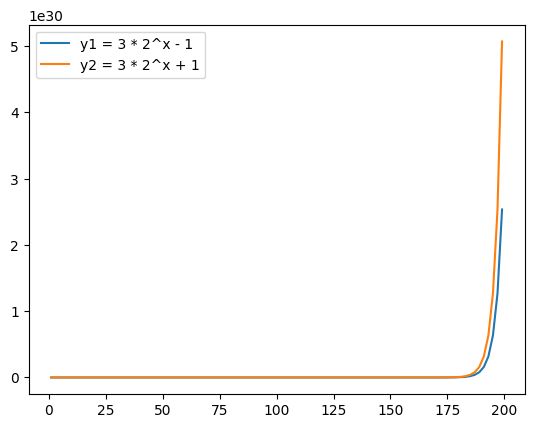

In [10]:
fig, ax = plt.subplots()
ax.plot(x, y1_list, label='y1 = 3 * 2^x - 1')
ax.plot(x, y2_list, label='y2 = 3 * 2^x + 1')
ax.legend()

In [3]:
error_rate = 0.0
circuit = stim.Circuit.generated("surface_code:rotated_memory_z",
                distance=4,
                rounds=2,
                after_clifford_depolarization=error_rate,
                before_round_data_depolarization=error_rate,
                before_measure_flip_probability=error_rate,
                after_reset_flip_probability=error_rate)

In [4]:
circuit

stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(6, 0) 6
    QUBIT_COORDS(7, 1) 7
    QUBIT_COORDS(1, 3) 10
    QUBIT_COORDS(2, 2) 11
    QUBIT_COORDS(3, 3) 12
    QUBIT_COORDS(4, 2) 13
    QUBIT_COORDS(5, 3) 14
    QUBIT_COORDS(6, 2) 15
    QUBIT_COORDS(7, 3) 16
    QUBIT_COORDS(0, 4) 18
    QUBIT_COORDS(1, 5) 19
    QUBIT_COORDS(2, 4) 20
    QUBIT_COORDS(3, 5) 21
    QUBIT_COORDS(4, 4) 22
    QUBIT_COORDS(5, 5) 23
    QUBIT_COORDS(6, 4) 24
    QUBIT_COORDS(7, 5) 25
    QUBIT_COORDS(8, 4) 26
    QUBIT_COORDS(1, 7) 28
    QUBIT_COORDS(2, 6) 29
    QUBIT_COORDS(3, 7) 30
    QUBIT_COORDS(4, 6) 31
    QUBIT_COORDS(5, 7) 32
    QUBIT_COORDS(6, 6) 33
    QUBIT_COORDS(7, 7) 34
    QUBIT_COORDS(2, 8) 38
    QUBIT_COORDS(6, 8) 42
    R 1 3 5 7 10 12 14 16 19 21 23 25 28 30 32 34 2 6 11 13 15 18 20 22 24 26 29 31 33 38 42
    TICK
    H 2 6 13 20 24 31 38 42
    TICK
    CX 2 3 20 21 13 14 31 32 6 7 24 25 19 18

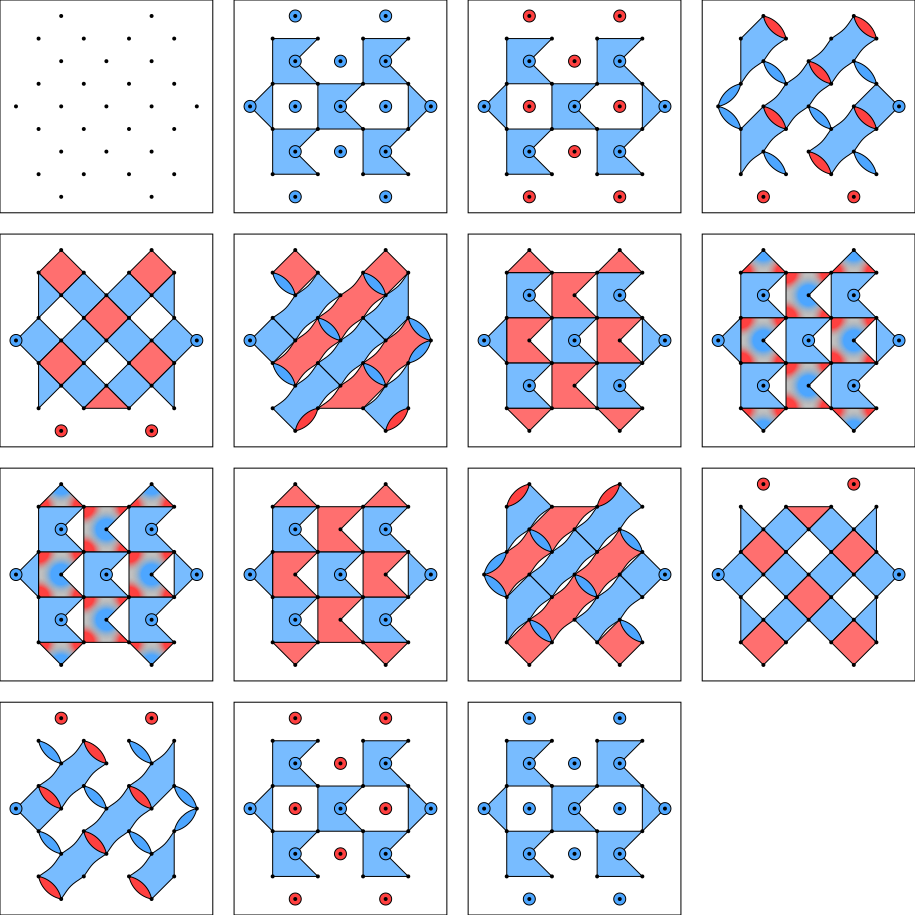

In [5]:
circuit.diagram('detslice-svg')

In [ ]:
class RepetitionCodeCircuit:
    """RepetitionCodeCircuit class."""

    def __init__(
        self,
        d: int,
        T: int,
        noise_angle: float = 0,
    ):
        """
        Creates the circuits corresponding to a logical 0 (or logical +1, if xbasis=True)
        using a repetition code.

        Implementation of a distance d repetition code, implemented over
        T syndrome measurement rounds.

        Args:
            d (int): Number of code qubits used.
            T (int): Number of rounds of syndrome measurements.

        """

        super().__init__()

        self.n = d
        self.d = d
        self.T = 0

        self.code_qubit = QuantumRegister(d, "code_qubit")
        self.measure_qubit = QuantumRegister((d - 1), "measure_qubit")
        self.qubit_registers = {"code_qubit", "measure_qubit"}

        self.measure_bits = []
        self.code_bit = ClassicalRegister(d, "code_bit")

        self.circuit = QuantumCircuit(self.measure_qubit, self.code_qubit)

        self.noise_angle = noise_angle

        for t in range(T):
            if self.noise_angle > 0.0 and t>0:
                self.inject_error(noise_angle = self.noise_angle)
            self.syndrome_measurement()
        self.readout()

    def syndrome_measurement(self):
        """Application of a syndrome measurement round.
        """

        self.measure_bits.append(ClassicalRegister((self.d - 1), "round_" + str(self.T) + "_measure_bit"))

        self.circuit.add_register(self.measure_bits[-1])

        # entangling gates
        self.circuit.barrier()
        for j in range(self.d - 1):
            self.circuit.cx(self.code_qubit[j], self.measure_qubit[j])
        for j in range(self.d - 1):
            self.circuit.cx(self.code_qubit[j + 1], self.measure_qubit[j])
        # measurement
        self.circuit.barrier()
        for j in range(self.d - 1):
            self.circuit.measure(self.measure_qubit[j], self.measure_bits[self.T][j])

        # self.circuit.barrier()
        # for j in range(self.d - 1):
        #     self.circuit.reset(self.measure_qubit[j])

        self.T += 1


    def readout(self):
        """
        Readout of all code qubits, which corresponds to a logical measurement
        as well as allowing for a measurement of the syndrome to be inferred.
        """
        self.circuit.add_register(self.code_bit)
        self.circuit.measure(self.code_qubit, self.code_bit)
    

    def inject_error(self, noise_angle=0):
        """
        Injects a coherent rotation error about a fixed axis (X-axis) on each code qubit,
        matching the protocol from https://www.nature.com/articles/s41586-024-08449-y (Fig. 2a).

        :param noise_angle: Rotation angle in radians to apply (deterministic).
        """
        for q in range(self.d):
            self.circuit.rx(noise_angle, self.code_qubit[q])

In [ ]:
d, d_t = 3, 2
alpha = 0.2
circuit_class_instance = RepetitionCodeCircuit(d, d_t, noise_angle=alpha)
circuit = circuit_class_instance.circuit
circuit.draw(output="mpl")

In [ ]:
transpiled_circuit = transpile(
            RepetitionCodeCircuit(d, d_t, noise_angle=alpha).circuit,
            backend=backend,
            initial_layout=None,
            routing_method="none",  # Disable SWAP-based routing
            optimization_level=1,
            seed_transpiler=42)
transpiled_circuit.draw(output="mpl", idle_wires=False)

In [ ]:
# Connect to backend
service = QiskitRuntimeService(token='P14sj-TbFhX7N_Vq2s6_ZFvnytlWbPJs_EDZ6Z1O3WXC', channel='ibm_quantum_platform')
backend_name = "ibm_miami"
backend = service.backend(backend_name)

In [ ]:
d, d_t = 17, 10
alphas = [0]#np.arange(0, np.pi/2 + 0.1, 0.1)
shots = 10_000
layout = None#[1, 3, 5, 7, 9, 18, 16, 14, 12, 10, 21, 23, 25, 27, 29, 38, 0, 2, 4,6,8,19, 17, 15, 13, 11, 20, 22, 24, 26, 28, 39, 37]

for alpha in alphas:
    transpiled_circuit = transpile(
            RepetitionCodeCircuit(d, d_t, noise_angle=alpha).circuit,
            backend=backend,
            initial_layout=layout,
            routing_method="none",  # Disable SWAP-based routing
            optimization_level=1,
            seed_transpiler=42)

    sampler = Sampler(mode=backend, options={"default_shots": shots})
    job = sampler.run([transpiled_circuit])
    job_result = job.result()
    res_filename_real_device = os.path.join(
        f"./jobdata_miami/",
        f"miami_z_basis_{job.job_id()}_d_{d}_d_t_{d_t}_"
        f"shots_{shots}_alpha_{alpha:.1f}.json")
    os.makedirs(os.path.dirname(res_filename_real_device), exist_ok=True)
    with open(res_filename_real_device, "w") as file:
        json.dump(job_result, file, cls=RuntimeEncoder)
    print(f"Measurement saved as '{res_filename_real_device}'")

buf = io.BytesIO()
qpy.dump(transpiled_circuit, buf)
blob = buf.getvalue()

with open(f"./jobdata_miami/miami_{job.job_id()}_d_{d}_d_t_{d_t}_alpha_{alpha:.1f}.qpy", "wb") as f:
    f.write(blob)

## Task: Decoding Experimental Repetition-Code Data with MWPM

1. **Compute and plot p_det(α).**  
   Load the processed CSV files and extract the mean detection probability p_det for each rotation angle α averaged over each subcode.  
   Make a plot of p_det versus α for each d. What is the shape of the curve and why?

2. **Plot P_L(p_det) for each distance.**  
   For each code distance d, plot the logical error rate P_L as a function of p_det.  
   Compare the curves across distances.  
   See whether the curves separate (distance suppresses logical errors) or collapse (no suppression).  
   If increasing d no longer lowers P_L, the system is effectively above threshold for this coherent-error setting.

3. **Convert to per-cycle logical error $\epsilon_L$.**  
   Assuming each round incurs a logical error with probability $\epsilon_L$, the total logical error rate $P_L$ after $T$ rounds is given by:  

   $P_L=\frac{1}{2}\left(1-\left(1-2 \epsilon_L\right)^T\right)$  

   Extract $\epsilon_L$ and plot it against p_det. Are we above threshold? Check the scaling behaviour. 


The error suppression factor $\Lambda$ as a practical metric for comparing the performance of various codes and decoders. We define $\Lambda$ through the scaling of the logical error rate $\epsilon_L$ as

$$
\epsilon_L \propto\left(\frac{1}{\Lambda}\right)^{\left\lfloor\frac{d}{2}\right\rfloor+1} .
$$


In [ ]:
class MWPMDecoder:
    """
    Minimum Weight Perfect Matching (MWPM) decoder for rep code syndrome data.

    This decoder uses PyMatching to construct a matching graph based on observed
    detection events from a quantum circuit, and predicts logical errors
    by decoding these using MWPM. Weights can be computed from pairwise detection correlations,
    """

    def __init__(self, distance, t, job_path, simulator, shots) -> None:
        """
        Initialize the MWPMDecoder.

        Parameters
        ----------
        args : Args
            Configuration object containing code parameters and backend settings.
        """
        self.distance = distance
        self.n_measures = distance - 1
        self.t = t
        self.job_path = job_path
        self.simulator = simulator
        self.shots = shots

    def _load_job_data(self) -> None:
        """
        Load syndrome and logical flip data from the sampler.
        """
        with open(self.job_path) as f:
            data = json.load(f, cls=RuntimeDecoder)

        if self.simulator:
            counts = data.get_counts()
        
        else:
            measure_regs = [f"round_{i}_measure_bit" for i in range(self.t)]
            all_regs = ["code_bit"] + measure_regs

            regs = {name: data[0].data[name].get_bitstrings() for name in all_regs}

            bitstrings = ["".join(bits) for bits in zip(*(regs[name] for name in all_regs))]
            counts = Counter(bitstrings)


        syndromes_no_reset_list, final_state_list = [], []
        for bitstring, freq in counts.items():
            # note: IBM bitorder, last data bit measured comes first
            bits = bitstring
            final_state_list.append((bits[:self.distance], freq))
            syndromes_no_reset_list.append((bits[self.distance:], freq))
    
        final_state = np.array([list(s[0]) for s in final_state_list], dtype=np.uint8)
        syndromes_no_reset = np.array([list(s[0]) for s in syndromes_no_reset_list], dtype=np.uint8) 

        freqs = np.array([s[1] for s in final_state_list], dtype=int)

        # repeat once at the end in NumPy
        final_state = np.repeat(final_state, freqs, axis=0) # shots, d
        syndromes_no_reset = np.repeat(syndromes_no_reset, freqs, axis=0) # (shots, d * d_t)

        # reverse time and qubit order to start from round 0 and qubit 0:
        syndromes_no_reset = syndromes_no_reset[:, ::-1]
        final_state = final_state[:, ::-1]
    
        # no reset used, so take diff in subsequent measurements
        # reshape to (n_shots, n_rounds, n_anc)
        syndromes_no_reset = syndromes_no_reset.reshape(-1, self.t, self.distance-1)
        # compute diff along time axis (rounds)
        diff = (syndromes_no_reset[:, 1:, :] != syndromes_no_reset[:, :-1, :]).astype(np.uint8)
        # prepend first measurement
        first = syndromes_no_reset[:, :1, :].astype(np.uint8)
        # the syndrome would look like this with resets:
        syndromes = np.concatenate([first, diff], axis=1) # (shots, d_t, d-1)
    
        # initial syndrome is all zeros:
        measures = self.distance - 1
        initial_syndrome = np.full((self.shots, measures), int(0), dtype=np.uint8)
    
        # final perfect syndrome measurement:
        final_syndrome = final_state[:, :-1] ^ final_state[:, 1:]
        # concatenate all syndrome measurements
        syndrome_matrix = np.concatenate([initial_syndrome, syndromes.reshape(self.shots, -1), final_syndrome], axis=1)
        # reshape to (shots, d_t + 2, d-1) (initial + d_t rounds + final)
        reshaped = syndrome_matrix.reshape(self.shots, self.t + 2, measures)
        # the detection events are given by changes in subsequent syndrome values:
        detections = np.diff(reshaped, axis=1).astype(bool)

        # subsample detection events by partitioning into smaller codes:
        self.partitions = {}
        self.logical_flips = {}

        for d in range(3, self.distance + 1, 2):
            n_meas = d - 1
            max_i = self.distance - d + 1

            for i in range(max_i):
                part = detections[:, :, i:i+n_meas]
                self.partitions[(d,i)] = part.reshape(self.shots, -1)
                # get equivalence class defined by first qubit
                self.logical_flips[(d,i)] = (final_state[:, i] == 1)


    def _error_correlation_matrix_full(self, detections) -> np.ndarray:
        """
        Compute the full correlation matrix from the observed detections.

        Returns
        -------
        pij_matrix : np.ndarray
            A symmetric matrix of error-pairing probabilities between detector events.
        """
        x = detections.astype(np.float64)  # shape (shots, N)

        # Compute means
        mean_i = x.mean(axis=0)  # shape (N,)
        mean_ij = (x.T @ x) / x.shape[0]  # shape (N, N)

        # Numerator and denominator
        numerator = mean_ij - np.outer(mean_i, mean_i)
        denominator = 1 - 2 * mean_i[:, None] - 2 * mean_i[None, :] + 4 * mean_ij

        with np.errstate(divide='ignore', invalid='ignore'):
            sqrt_term = np.sqrt(1 - 4 * numerator / denominator)
            pij = 0.5 - 0.5 * sqrt_term

        pij = np.where(np.isfinite(pij), pij, 0.0)  # Replace NaNs and infs with 0.0
        np.fill_diagonal(pij, 0.0)  # set diagonal to 0 for clarity

        return pij

    
    def get_edges(self, detections, d) -> None:
        """
        Build the matching graph with edges weighted according to the selected weight scheme.

        Constructs both space-like (within a time slice) and time-like (between time slices) edges.
        Edge weights are derived from the negative log of correlation coefficients.
        """
        row_len = d - 1
        error_correlation = self._error_correlation_matrix_full(detections)
            
        error_correlation[error_correlation <= 0] = 1e-7  # Avoid log(0) or negative weights
            
        weights = -np.log(error_correlation)
        matcher = pymatching.Matching()

        # Add space-like edges (horizontal, within each time slice)
        for t_index in range(self.t + 1):
            row_start = t_index * row_len
            row_end = row_start + row_len

            for i in range(row_start, row_end - 1):
                matcher.add_edge(
                    i, i + 1,
                    weight=weights[i][i + 1],
                    fault_ids={i % row_len + 1},
                    merge_strategy='replace'
                )

            matcher.add_boundary_edge(
                row_start,
                weight=weights[row_start][row_start + 1],
                fault_ids={0},
                merge_strategy='replace'
            )

            matcher.add_boundary_edge(
                row_end - 1,
                weight=weights[row_end - 2][row_end - 1],
                fault_ids={row_len},
                merge_strategy='replace'
            )
        # Add time-like edges (vertical, across time slices)
        for t_index in range(self.t):
            for offset in range(row_len):
                i = t_index * row_len + offset
                j = i + row_len
                matcher.add_edge(
                    i, j,
                    weight=weights[i][j],
                    merge_strategy='replace'
                )
        return matcher
    
    def _evaluate_predictions(self, matcher, detections, logical_flips) -> float:
        """
        Evaluate decoder accuracy using.

        Returns
        -------
        logical_accuracy : float
            Logical decoding accuracy, including both trivial and non-trivial shots.
        """

        # Filter out trivial syndromes
        nontrivial = np.any(detections, axis=1)
        detections_nt = detections[nontrivial]
        flips_nt = logical_flips[nontrivial]
        # Decode predictions using MWPM
        predictions = matcher.decode_batch(detections_nt)

        predicted = predictions[:, 0]
        correct = np.sum(flips_nt == predicted)
        trivial_count = np.sum(~nontrivial)

        logical_accuracy = (correct + trivial_count) / detections.shape[0]
        logical_accuracy_err = np.sqrt(logical_accuracy * (1-logical_accuracy) / detections.shape[0])

        return logical_accuracy, logical_accuracy_err

    def decode(self) -> float:
        """
        Full decoding pipeline: load data, construct the graph, run decoding, and return accuracy.

        Returns
        -------
        logical_accuracy : float
            Logical accuracy on the validation set.
        """

        P_L = {}
        self._load_job_data()
        for d, i in self.partitions:
            n_measures = d - 1
            detections = self.partitions[(d, i)]
            logical_flips = self.logical_flips[(d, i)]
            matcher = self.get_edges(detections, d)
            pdet_mean = detections.mean()
            logical_accuracy, logical_accuracy_err = self._evaluate_predictions(matcher, detections, logical_flips)
            P_L[(d, i)] = 1 - logical_accuracy, logical_accuracy_err, pdet_mean
            if i == 0:
                print(f"d={d}, i={i}, pdet={pdet_mean:.4f}, P_L={1 - logical_accuracy:.6f} ± {logical_accuracy_err:.6f}")
        return P_L


In [ ]:
def run_folder(folder, distance, t, simulator, shots):
    files = [f for f in os.listdir(folder) if f.endswith(".json")]

    for f in files:
        out = os.path.join(folder, f.replace(".json", ".csv"))
        if os.path.exists(out):
            print("skip", out)
            continue

        path = os.path.join(folder, f)
        dec = MWPMDecoder(distance, t, path, simulator, shots)
        P_L = dec.decode()

        rows = []
        for (d, i), (p_l, err, pdet) in P_L.items():
            rows.append({"d": d, "i": i, "P_L": p_l, "err": err, "pdet_mean": pdet})

        pd.DataFrame(rows).to_csv(out, index=False)
        print("saved", out)


In [ ]:
run_folder("./jobdata_miami/", 17, 10, simulator=False, shots=10_000)

In [ ]:
def load_csvs(folder):
    rows = []
    files = [f for f in os.listdir(folder) if f.endswith(".csv")]

    for f in files:
        m_alpha = re.search(r"alpha_([0-9.]+)", f)
        if not m_alpha:
            continue

        alpha_str = m_alpha.group(1).rstrip(".")
        df = pd.read_csv(os.path.join(folder, f))

        for _, r in df.iterrows():
            rows.append({
                "alpha": alpha_str,
                "d": int(r["d"]),
                "P_L": r["P_L"],
                "err": r["err"],
                "p_det": r["pdet_mean"],
            })

    df = pd.DataFrame(rows)

    g = df.groupby(["alpha","d"]).agg(
        P_L=("P_L","mean"),
        dPL=("err","mean"),           # average err over i
        p_det=("p_det","mean")
    ).reset_index()

    g["alpha"] = g["alpha"].astype(float)
    return g

In [ ]:

def epsilon_from_PL(PL: float, T: int) -> float:
    """
    Invertera PL (logisk felprob per T cykler) till epsilon per cykel.
    Clippar vid 0.5 för ogiltiga/stora PL.
    """
    PL = np.asarray(PL, dtype=float)  # ensures array operations
    eps = 0.5 * (1.0 - (1.0 - 2.0 * PL) ** (1.0 / T))
    return np.clip(eps, None, 0.5)

def epsilon_err_from_PL(PL, dPL, T: int):
    """
    Propagate uncertainty dPL -> epsilon.
    dε/dPL = (1/T) * (1 - 2PL)^(1/T - 1)
    So: dε = |dε/dPL| * dPL
    
    Works with scalars and arrays.
    """
    PL = np.asarray(PL, dtype=float)
    dPL = np.asarray(dPL, dtype=float)

    deriv = (1.0 / T) * (1.0 - 2.0 * PL) ** (1.0 / T - 1.0)
    deps = np.abs(deriv) * dPL

    # set to 0 where PL >= 0.5
    deps = np.where(PL >= 0.4, 0.0, deps)

    return deps
def plot_results(folder, T=10):
    data = load_csvs(folder)
    if data.empty:
        print("no csvs found")
        return

    # epsilon + propagated error
    data["eps"] = epsilon_from_PL(data["P_L"], T)
    data["deps"] = epsilon_err_from_PL(data["P_L"], data["dPL"], T)

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    ax = ax.flatten()

    # ---------- (1) p_det vs alpha ----------
    for d in sorted(data["d"].unique()):
        sub = data[data["d"] == d].sort_values("alpha")
        ax[0].plot(sub["alpha"], sub["p_det"], "o", label=f"d={d}")

    ax[0].set_xlabel("alpha")
    ax[0].set_ylabel("p_det")
    ax[0].set_title("p_det vs alpha")
    ax[0].legend()

    # ---------- (2) P_L vs p_det ----------
    for d in sorted(data["d"].unique()):
        sub = data[data["d"] == d].sort_values("p_det")
        ax[1].errorbar(
            sub["p_det"],
            sub["P_L"],
            yerr=sub["dPL"],
            fmt="o",
            capsize=3,
            label=f"d={d}",
        )

    ax[1].set_xlabel("p_det")
    ax[1].set_ylabel("P_L")
    ax[1].set_title("P_L vs p_det")
    ax[1].set_xscale("linear")
    ax[1].set_yscale("linear")

    # ---------- (3) epsilon vs p_det (log–log) ----------
    slopes = []
    
    for d in sorted(data["d"].unique()):
        sub = data[data["d"] == d].sort_values("p_det")
        cut = 9
        # skip last few near-0.5 points
        sub = sub.iloc[:-cut]
    
        # keep only eps > 0
        mask = sub["eps"] > 0
        sub = sub[mask]
    
        # plot data points
        pts = ax[2].errorbar(
            sub["p_det"],
            sub["eps"],
            yerr=sub["deps"],
            fmt="o",
            capsize=3,
            label=f"d={d}"
        )
        color = pts[0].get_color()
    
        # --- FIT IN LOG–LOG SPACE ---
        x = np.log(sub["p_det"].values)
        y = np.log(sub["eps"].values)
    
        A = np.vstack([x, np.ones_like(x)]).T
        slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
        slopes.append((d, slope))
    
        # --- PLOT FITTED LINE (same subplot) ---
        xfit = np.linspace(x.min(), x.max(), 200)
        yfit = slope * xfit + intercept
    
        ax[2].plot(np.exp(xfit), np.exp(yfit), "-", alpha=0.7, color = color)
    
    ax[2].set_xlabel("p_det")
    ax[2].set_ylabel("eps")
    ax[2].set_title("epsilon vs p_det (log–log)")
    ax[2].set_xscale("log")
    ax[2].set_yscale("log")
    ax[2].set_ylim(1e-7, 1)
    
    # ---------- (4) slope vs d ----------
    slopes = np.array(slopes)
    ax[3].plot(slopes[:,0], slopes[:,1], "o")

    ax[3].set_xlabel("d")
    ax[3].set_ylabel("slope")
    ax[3].set_title("log–log slope of epsilon vs p_det")

# ---------- (6) lambda vs alpha ----------
    # compute lambda(alpha) by averaging eps(d)/eps(d+2)
    lambdas = []

    for alpha in sorted(data["alpha"].unique()):
        sub = data[data["alpha"] == alpha].sort_values("d")

        ds = sub["d"].values
        eps = sub["eps"].values
        p_det = sub["p_det"].values

        lam_vals = []
        for i in range(len(ds)-1):
            if ds[i+1] == ds[i] + 2 and eps[i] > 0 and eps[i+1] > 0:
                lam_vals.append(eps[i] / eps[i+1])

        if lam_vals:
            lambdas.append({
                "p_det": p_det[-1],
                "lambda":  1 / np.mean(lam_vals)
            })

    df_lambda = pd.DataFrame(lambdas)

    fig6, ax6 = plt.subplots(figsize=(6,5))
    ax6.plot(df_lambda["p_det"], df_lambda["lambda"], "o")

    ax6.set_xlabel("p_det")
    ax6.set_ylabel("Lambda")
    ax6.set_title("Lambda vs p_det (averaged over d)")
    ax6.set_yscale("log")

    plt.tight_layout()
    plt.show()


In [ ]:
plot_results("jobdata_kez-reset/")

In [ ]:

df = pd.read_csv("jobdata_solutions_kez/kez_z_basis_d4km6k2v0j9c73e4h2p0_d_17_d_t_10_shots_20000_alpha_0.7.csv")

# build a continuous colormap for i
i_vals = df["i"].values
norm = plt.Normalize(vmin=i_vals.min(), vmax=i_vals.max())
cmap = plt.cm.viridis   # choose any gradient

fig, ax = plt.subplots(figsize=(8,6))

for d in sorted(df["d"].unique()):
    sub = df[df["d"] == d].sort_values("i")

    colors = cmap(norm(sub["i"].values))

    ax.scatter(
        sub["d"],
        sub["pdet_mean"],
        c=colors,
        label=f"d={d}",
        s=40
    )

# colorbar for i
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("i")

ax.set_xlabel("distance d")
ax.set_ylabel("p_det")
ax.set_title("p_det vs d with color gradient over i")

plt.tight_layout()
plt.show()


In [ ]:

with open('jobdata_solutions_kez/kez_z_basis_d4km6843tdfc73doljag_d_17_d_t_10_shots_20000_alpha_0.3.json') as f:
    data = json.load(f, cls=RuntimeDecoder)
d_t = 10
d = 17
shots = 20_000
# build the list in the right order
measure_regs = [f"round_{i}_measure_bit" for i in range(d_t)]
all_regs = ["code_bit"] + measure_regs

regs = {name: data[0].data[name].get_bitstrings() for name in all_regs}

run_data = []
for bits in zip(*(regs[name] for name in all_regs)):
    code = bits[0]
    rounds = " ".join(bits[1:])
    run_data.append(f"{code} {rounds}")

counts = dict(Counter(run_data))

syndromes_no_reset_list, final_state_list = [], []
for bitstring, freq in counts.items():
    bits = bitstring.replace(" ", "")
    final = [b == "1" for b in bits[:d]]
    # note: IBM bitorder, last data bit measured comes first
    syndrome_no_reset = [b == "1" for b in bits[d:]]
    syndromes_no_reset_list.extend([syndrome_no_reset] * freq)
    final_state_list.extend([final] * freq)

final_state = np.array(final_state_list, dtype=np.uint8) # shots, d
syndromes_no_reset = np.array(syndromes_no_reset_list, dtype=np.uint8) # (shots, d * d_t)
# reverse time and qubit order to start from round 0 and qubit 0:
syndromes_no_reset = syndromes_no_reset[:, ::-1]
final_state = final_state[:, ::-1] #TODO: check if needed

# no reset used, so take diff in subsequent measurements
# reshape to (n_shots, n_rounds, n_anc)
syndromes_no_reset = syndromes_no_reset.reshape(-1, d_t, d-1)
# compute diff along time axis (rounds)
diff = (syndromes_no_reset[:, 1:, :] != syndromes_no_reset[:, :-1, :]).astype(np.uint8)
# prepend first measurement
first = syndromes_no_reset[:, :1, :].astype(np.uint8)
# the syndrome would look like this with resets:
syndromes = np.concatenate([first, diff], axis=1) # (shots, d_t, d-1)

# initital syndrome is all zeros:
measures = d - 1
initial_syndrome = np.full((shots, measures), int(0), dtype=np.uint8)

# final perfect syndrome measurement:
final_syndrome = final_state[:, :-1] ^ final_state[:, 1:]
# concatenate all syndrome measurements
syndrome_matrix = np.concatenate([initial_syndrome, syndromes.reshape(shots, -1), final_syndrome], axis=1)
# reshape to (shots, d_t + 2, d-1) (initial + d_t rounds + final)
reshaped = syndrome_matrix.reshape(shots, d_t + 2, measures)
# the detection events are given by changes in subsequent syndrome values:
detections = np.diff(reshaped, axis=1).astype(bool)




heat = detections.mean(axis=0).T        # (measures, T-1)
h_mean_time = heat.mean(axis=1)[:,None] # (measures, 1)
h_mean_anc  = heat.mean(axis=0)[None,:] # (1, T-1)

fig = plt.figure(figsize=(9,6))

# main heat map
ax = fig.add_axes([0.1, 0.3, 0.55, 0.55])
im = ax.imshow(heat, aspect='auto')
plt.colorbar(im, ax=ax)
ax.set_xlabel('time')
ax.set_ylabel('measure index')

# right marginal heat map
ax_r = fig.add_axes([0.7, 0.3, 0.15, 0.55], sharey=ax)
im_r = ax_r.imshow(h_mean_time, aspect='auto')
ax_r.set_xticks([])
plt.colorbar(im_r, ax=ax_r)

# bottom marginal heat map
ax_b = fig.add_axes([0.1, 0.1, 0.55, 0.15], sharex=ax)
im_b = ax_b.imshow(h_mean_anc, aspect='auto')
ax_b.set_yticks([])
plt.colorbar(im_b, ax=ax_b)
plt.show()



grouped_counts = defaultdict(dict)
for bitstring, count in counts.items():
    data, *syndrome = bitstring.split()
    grouped_counts[data][" ".join(syndrome)] = count
totals = {data: sum(subcounts.values())
          for data, subcounts in grouped_counts.items()}

bitlen = len(next(iter(totals)))
flip_counts = np.zeros(bitlen, dtype=int)

for bitstring, c in totals.items():
    bits = np.fromiter((b == '1' for b in bitstring), dtype=bool)
    flip_counts += bits * c
plt.bar(range(len(flip_counts)), flip_counts)
plt.xticks(range(len(flip_counts)))
plt.xlabel("data index")
plt.ylabel("1 counts")
plt.show()